# Experimentation

## Changelog
### 1.0.0:
- initial setup

### 1.0.1:
- rescaling to 1/127
- limit visualisations

### 1.0.2:
- train with validation data
- train on 50 epochs
- add (early stopping & reduce on lr) callbacks
- add visualisations
- fix seed (for reproducalble results)

In [1]:
# python core packages
import os
import sys
import pickle

# 3rd party packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# fix seed
np.random.seed(1234)
tf.random.set_seed(4567)

print(f'\n-> Python: {sys.version}')
print(f'-> Tensorflow: {tf.__version__}')

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2

-> Python: 3.9.2 (v3.9.2:1a79785e3e, Feb 19 2021, 09:06:10) 
[Clang 6.0 (clang-600.0.57)]
-> Tensorflow: 2.5.0-rc1


## Load the data

In [2]:
with open(os.path.join(os.pardir, 'data', 'processed', 'traffic-signs-data', 'train.p'), mode='rb') as f:
    train = pickle.load(f)
    
with open(os.path.join(os.pardir, 'data', 'processed', 'traffic-signs-data', 'valid.p'), mode='rb') as f:
    valid = pickle.load(f)
    
with open(os.path.join(os.pardir, 'data', 'processed', 'traffic-signs-data', 'test.p'), mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:3]
print(f'-> Image data shape = {image_shape}')

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))
print(f'-> Number of classes = {n_classes}')

# load the sign data
signnames = pd.read_csv(os.path.join(os.pardir, 'data', 'processed', 'signnames.csv')).set_index('ClassId')

# create a label_map
class_names = signnames.to_dict()['SignName']

# show some
signnames.head()

-> Image data shape = (32, 32)
-> Number of classes = 43


,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)


## Preprocess the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-> Image normalization check; min=-0.8666666746139526, max=-0.4431372284889221


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

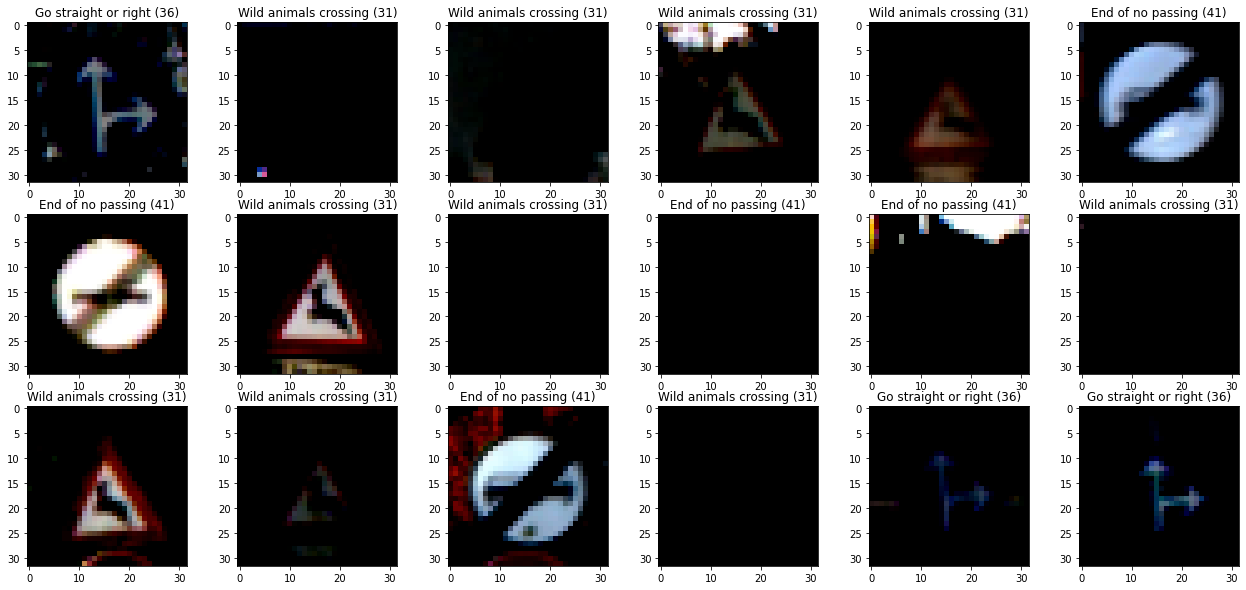

In [3]:
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

# =============================================================================
# load data
# =============================================================================

# create tensorflow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# =============================================================================
# prepare
# =============================================================================

def plot_dataset(dataset, n_columns = 6, n_rows = 3):
    plt.figure(figsize=(22, 10))
    for images, labels in dataset.take(1):
        for i in range(n_columns * n_rows):
            ax = plt.subplot(n_rows, n_columns, i + 1)
            plt.imshow(images[i].numpy(), cmap=plt.cm.binary)
            plt.title(f'{class_names[labels[i].numpy()]} ({labels[i].numpy()})')

def preprocess(image, label):
    # cast the input
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.int32)
    
    # process the image
    rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
    image = rescale(image)
    
    # return 
    return image, label

def prepare(dataset):
    # Cast
    dataset = dataset.map(lambda x, y: preprocess(x, y), num_parallel_calls=AUTOTUNE)

    return dataset

# prepare the data(sets)
train_ds = prepare(train_ds)
valid_ds = prepare(valid_ds)
test_ds = prepare(test_ds)

# check if normalization works between [0,1]
image_batch, labels_batch = next(iter(train_ds))
print(f'-> Image normalization check; min={np.min(image_batch[0])}, max={np.max(image_batch[0])}')

# plot some training images
plot_dataset(train_ds)

## Model architecture

In [4]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(n_classes)
])

# compile the model
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

# show a summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 43)                5547      
Total params: 398,891
Trainable params: 398,891
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [5]:
# callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=6),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5),
]

# train the model
history = model.fit(
    train_ds, 
    epochs=50,
    validation_data=valid_ds,
    callbacks=callbacks,
)

Epoch 1/50
272/272 [==============================] - 3s 9ms/step - loss: 3.7021 - accuracy: 0.4682 - val_loss: 11.0546 - val_accuracy: 0.1272
Epoch 2/50
272/272 [==============================] - 2s 6ms/step - loss: 3.5984 - accuracy: 0.4410 - val_loss: 11.7975 - val_accuracy: 0.1544
Epoch 3/50
272/272 [==============================] - 2s 9ms/step - loss: 2.8837 - accuracy: 0.5093 - val_loss: 8.6494 - val_accuracy: 0.1771
Epoch 4/50
272/272 [==============================] - 2s 7ms/step - loss: 2.1287 - accuracy: 0.5540 - val_loss: 9.7656 - val_accuracy: 0.1991
Epoch 5/50
272/272 [==============================] - 2s 8ms/step - loss: 2.0656 - accuracy: 0.6028 - val_loss: 11.8345 - val_accuracy: 0.1846
Epoch 6/50
272/272 [==============================] - 2s 7ms/step - loss: 1.9595 - accuracy: 0.6238 - val_loss: 8.6436 - val_accuracy: 0.2134
Epoch 7/50
272/272 [==============================] - 2s 6ms/step - loss: 1.6988 - accuracy: 0.6278 - val_loss: 10.0094 - val_accuracy: 0.2163
Ep

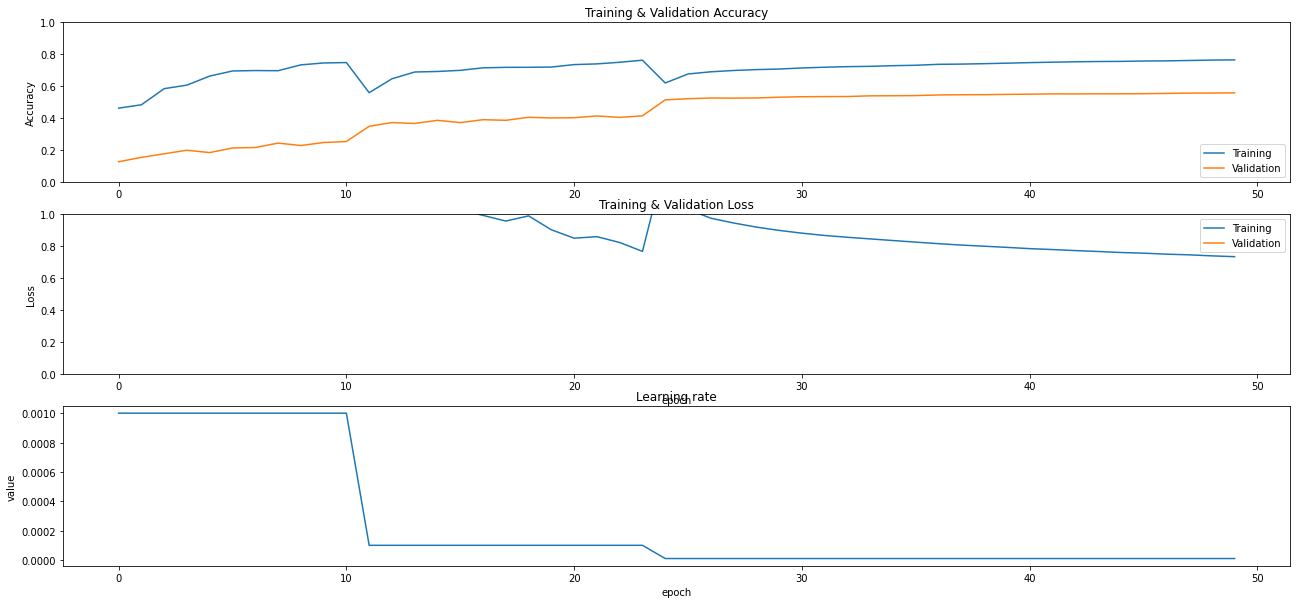

In [6]:
plt.figure(figsize=(22, 10))

# summarize history for accuracy
plt.subplot(3, 1, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Training & Validation Accuracy')

# summarize history for loss
plt.subplot(3, 1, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training & Validation Loss')
plt.xlabel('epoch')

# summarize history for learning rate
plt.subplot(3, 1, 3)
plt.plot(history.history['lr'])
plt.title('Learning rate')
plt.ylabel('value')
plt.xlabel('epoch')

plt.show()

## Evaluate the model

[Text(0.5, 0, 'Accuracy'), Text(0, 0.5, 'dataset'), (0.0, 1.0)]

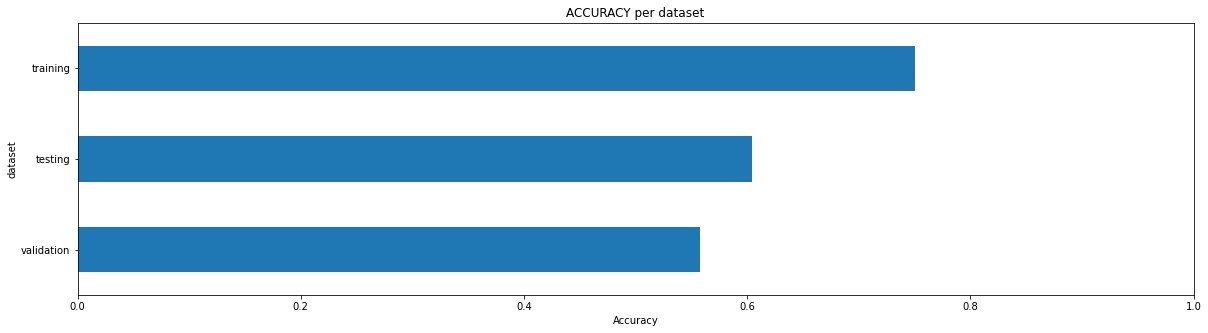

In [7]:
bechmarks = []

loss, acc = model.evaluate(train_ds, verbose=0)
bechmarks.append({'dataset':'training', 'accuracy':acc, 'loss':loss})

loss, acc = model.evaluate(valid_ds, verbose=0)
bechmarks.append({'dataset':'validation', 'accuracy':acc, 'loss':loss})

loss, acc = model.evaluate(test_ds, verbose=0)
bechmarks.append({'dataset':'testing', 'accuracy':acc, 'loss':loss})

# plot the accuracy per dataset
pd.DataFrame(bechmarks)\
    .set_index('dataset')\
    .sort_values('accuracy', ascending=True)['accuracy']\
    .plot(kind='barh', figsize=(20, 5), title='ACCURACY per dataset')\
    .set(xlabel="Accuracy", ylabel="dataset", xlim=[0,1.0])